In [1]:
%load_ext autoreload
%autoreload 2
import os
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
from SRtools import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
import numpy as np
from SRtools import SR_hetro as srh
from SRtools import presets
import matplotlib.pyplot as plt
from SRtools import readResultsBaysian as rrb
from matplotlib import image as mpimg
from matplotlib import offsetbox
from SRtools import utils


In [2]:
index_offset = 0
save_fig = True

In [3]:
config_excel_file_path = 'configurations_baysian.xlsx'


config_names_full = ['mice_F', 'mice_M', 'yeast', 'celegans', 'ecoli', 'cats_vp_M', 'cats_vp_F',
 'drosophila_853', 'drosophila_707', 'drosophila_441', 'drosophila_217',
  'Sweden_M_1910_hetro', 'Sweden_F_1910_homo', 'Sweden_F_1910_hetro', 'Denmark_M_1900_hetro', 'Denmark_M_1900_homo', 'Denmark_M_1890_hetro', 'Denmark_M_1890_homo', 'Denmark_F_1900_hetro', 'Denmark_F_1890_hetro',
   'Staffy_vetCompass', 'Labradors_vetCompass', 'Jack_Russell_vetCompass', 'German_Shepherd_vetCompass',
    ]#'Guiniea_pig_VC']

config_names_fig2 = ['mice_M', 'mice_F', 'yeast', 'celegans', 'ecoli', 'cats_vp_M', 'cats_vp_F',
 'drosophila_853', 'drosophila_707', 'drosophila_441', 'drosophila_217',
  'Denmark_M_1900_hetro', 'Denmark_F_1900_hetro',
   'Staffy_vetCompass', 'Labradors_vetCompass', 'Jack_Russell_vetCompass', 'German_Shepherd_vetCompass',
   'Guiniea_pig_VC'
  ]

In [4]:
data_sets_path = {}
dataSets = {}
time_ranges = {}
bestSims = {}


for config_name in config_names_fig2:
    config = cl.read_excel_config(config_excel_file_path, config_name)
    cfg = cl.config_to_dict(config, mcmc_convert=True)
    ds_path = data_file = cfg.get('data_file')

    # ensure ds_path includes 'datasets/' at the start
    if not ds_path.startswith('datasets/'):
        ds_path = 'datasets/' + ds_path.split('datasets/')[-1]
    
    data_sets_path[config_name] = ds_path
    dataSets[config_name] = dtds.dsFromFile(ds_path,properties=['death dt'])

    time_range = presets.get_config_params(config_name,['time_range'],[list])['time_range']
    time_ranges[config_name] = time_range

    sim = presets.getSim(config_name,type='max_likelihood')
    bestSims[config_name] = sim

coarse_grained = False


Converting time units: days -> weeks (s=7.0)
Converting time units: days -> weeks (s=7.0)
Converting time units: days -> generations (s=0.125)
Using alias 'celegans' -> 'celegans'
Using alias 'celegans' -> 'celegans'
Using alias 'celegans' -> 'celegans'
Converting time units: days -> hours (s=0.041666666666666664)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Using alias 'Staffy_vetCompass' -> 'Staffy_vetCompass'
Using alias 'Staffy_vetCompass' -> 'Staffy_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Staffy_vetCompass' -> 'Staffy_vetCompass'
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)


In [5]:
thetas = {}

for config_name in config_names_full:
    theta = presets.getTheta(config_name)
    thetas[config_name] = theta

Converting time units: days -> weeks (s=7.0)
Converting time units: days -> weeks (s=7.0)
Converting time units: days -> generations (s=0.125)
Using alias 'celegans' -> 'celegans'
Converting time units: days -> hours (s=0.041666666666666664)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Using alias 'Staffy_vetCompass' -> 'Staffy_vetCompass'
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0)
Converting time units: days -> years (s=365.0

In [6]:
print(dataSets.keys())

dict_keys(['mice_M', 'mice_F', 'yeast', 'celegans', 'ecoli', 'cats_vp_M', 'cats_vp_F', 'drosophila_853', 'drosophila_707', 'drosophila_441', 'drosophila_217', 'Denmark_M_1900_hetro', 'Denmark_F_1900_hetro', 'Staffy_vetCompass', 'Labradors_vetCompass', 'Jack_Russell_vetCompass', 'German_Shepherd_vetCompass', 'Guiniea_pig_VC'])


/var/folders/pr/hngn4yrn3v3gt3069stbsfqh0000gp/T/ipykernel_59906/3583230330.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('plasma', len(dataSets.keys()))


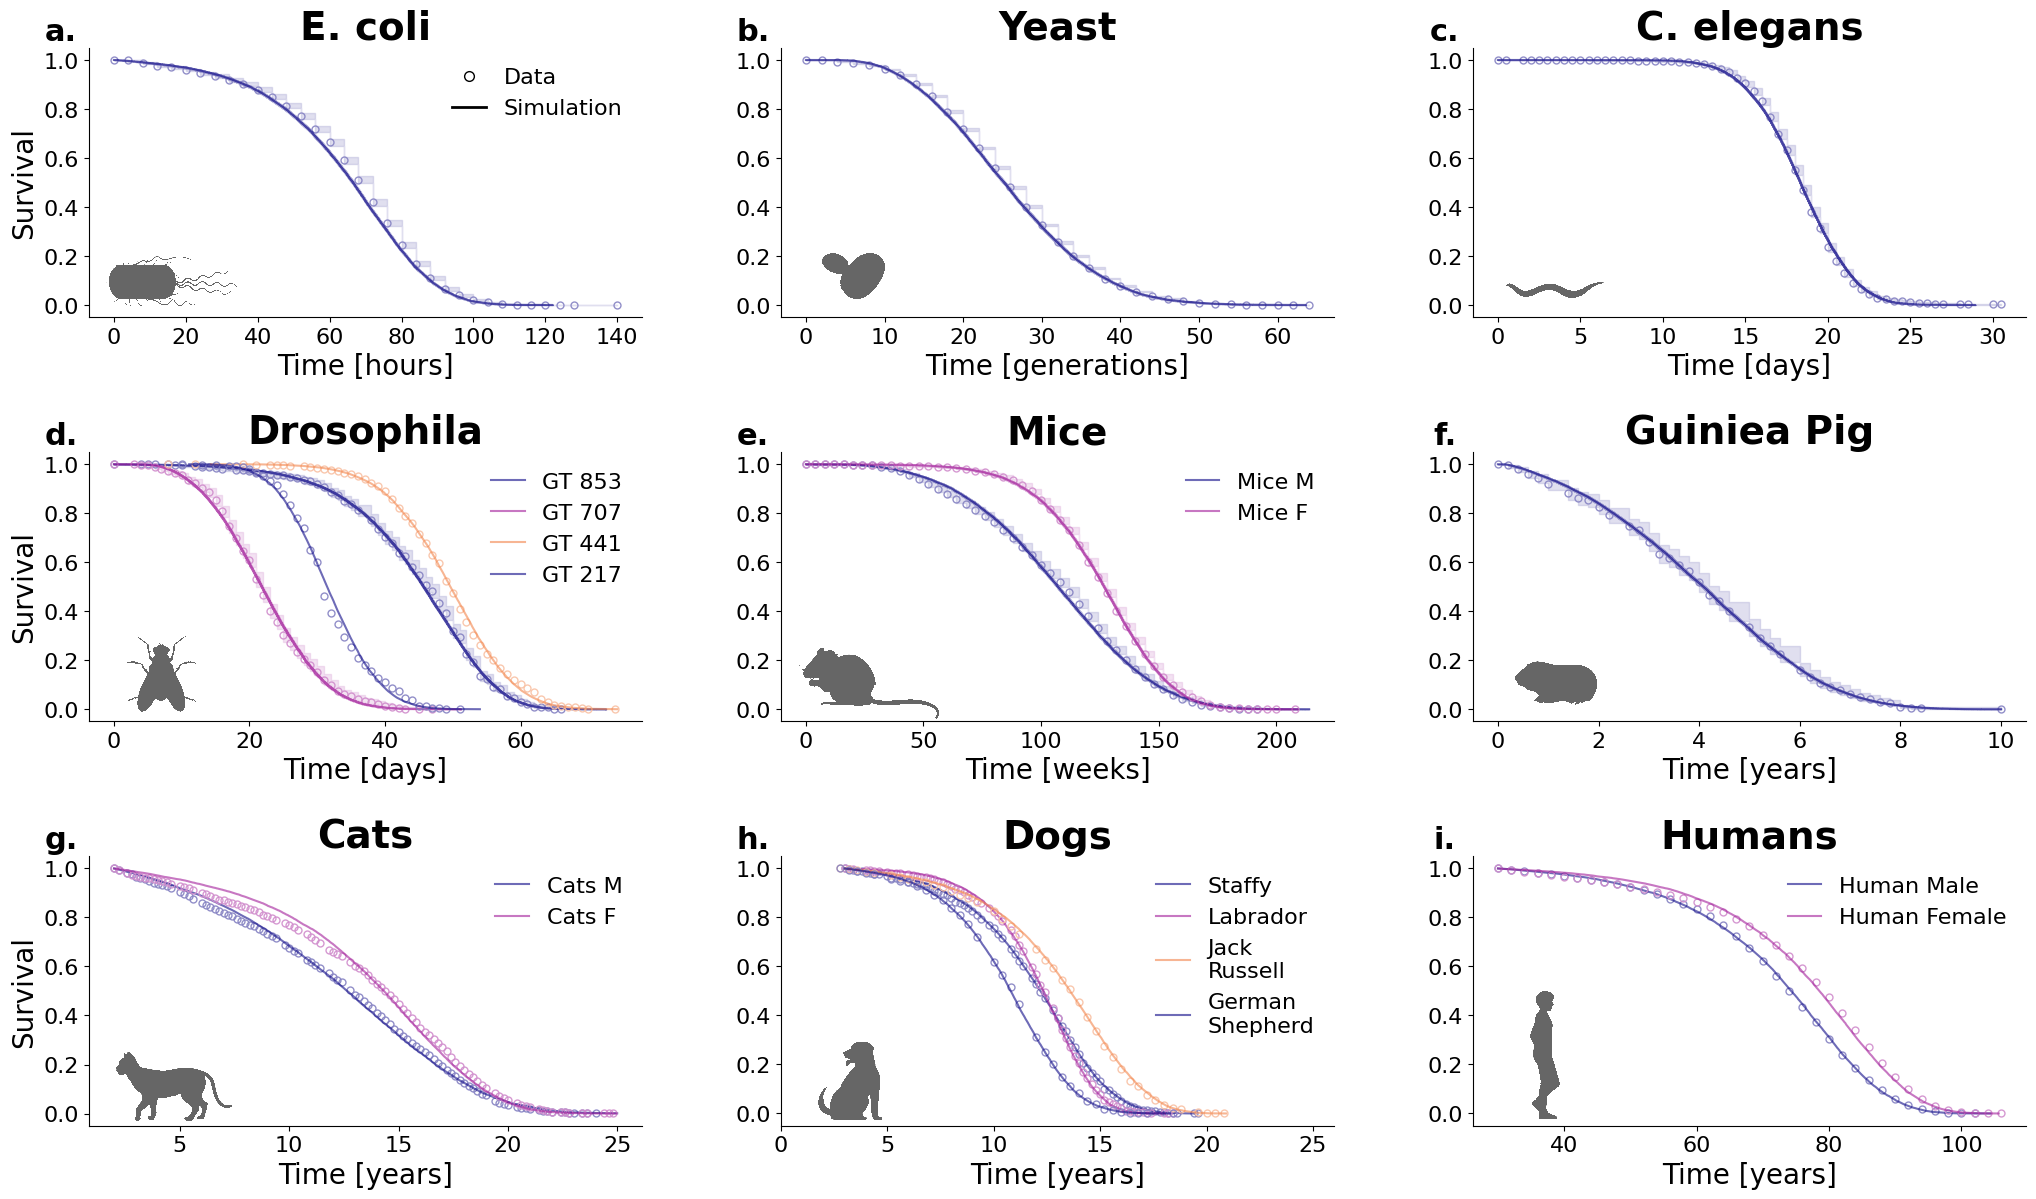

In [8]:
# Plot a 3 by 3 grid of the best fits of survival and data where each panel is a different organism
# We have 9 panels: ecoli, yeast, celegans, drosophila, mice, guinea pig, cats, dogs, humans

fig, axs = plt.subplots(3, 3, figsize=(25, 14))
axs = axs.ravel()
# add padding between the plots
fig.subplots_adjust(hspace=0.5, wspace=0.25)
# add numbering to the plots, in the top left corner of each panel
for i, ax in enumerate(axs):
    ax.text(-0.05, 1.06, f'{chr(97 + index_offset + i)}.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=22, weight='bold', color='black')

labels = {'ecoli':'E. coli',
           'yeast': 'Yeast',
           'celegans': 'C. elegans',
           'drosophila_441': 'GT 441',
           'drosophila_217': 'GT 217',
           'drosophila_707': 'GT 707',
           'drosophila_853': 'GT 853',
           'mice_F': 'Mice F',
           'mice_M': 'Mice M',
           'cats_vp_M': 'Cats M',
           'cats_vp_F': 'Cats F',
           'Labradors_vetCompass': 'Labrador',
           'Staffy_vetCompass': 'Staffy',
           'Jack_Russell_vetCompass': 'Jack\nRussell',
           'German_Shepherd_vetCompass': 'German\nShepherd',
           'Denmark_M_1900_hetro': 'Human Male',
           'Denmark_F_1900_hetro': 'Human Female',
           'Guiniea_pig_VC': 'Guiniea Pig'
}

species = {'ecoli':'E. coli',
           'yeast': 'Yeast',
           'celegans': 'C. elegans',
           'drosophila_441': 'Drosophila Melanogaster',
           'drosophila_217': 'Drosophila Melanogaster',
           'drosophila_707': 'Drosophila Melanogaster',
           'drosophila_853': 'Drosophila Melanogaster',
           'mice_F': 'Mice',
           'mice_M': 'Mice',
           'cats_vp_M': 'Cats',
           'cats_vp_F': 'Cats',
           'Labradors_vetCompass': 'Dogs',
           'Staffy_vetCompass': 'Dogs',
           'Jack_Russell_vetCompass': 'Dogs',
           'German_Shepherd_vetCompass': 'Dogs',
           'Denmark_M_1900_hetro': 'Humans',
           'Denmark_F_1900_hetro': 'Humans',
           'Guiniea_pig_VC': 'Guiniea Pig'
}

ax_dict = {
    'E. coli': axs[0],
    'Yeast': axs[1],
    'C. elegans': axs[2],
    'Drosophila Melanogaster': axs[3],
    'Mice': axs[4],
    'Guiniea Pig': axs[5],
    'Cats': axs[6],
    'Dogs': axs[7],
    'Humans': axs[8]
}

times_dict = {
    'E. coli': 'hours',
    'Yeast': 'generations',
    'C. elegans': 'days',
    'Drosophila Melanogaster': 'days',
    'Mice': 'weeks',
    'Guiniea Pig': 'years',
    'Cats': 'years',
    'Dogs': 'years',
    'Humans': 'years'
}

img_dict = {
    'E. coli': 'silhouetts/ecoli.jpeg',
    'Yeast': 'silhouetts/yeast.jpg',
    'C. elegans': 'silhouetts/celegance.jpeg',
    'Drosophila Melanogaster': 'silhouetts/fly silhouette.jpeg',
    'Mice': 'silhouetts/mice.jpg',
    'Guiniea Pig': 'silhouetts/guinea_pig_silhouette.jpeg',
    'Cats': 'silhouetts/cat silhouette.jpeg',
    'Dogs': 'silhouetts/Labrador.jpg',
    'Humans': 'silhouetts/man silhouette.jpeg'
}

zoom_dict = {
    'E. coli': 0.025,
    'Yeast': 0.02,
    'C. elegans': 0.025,
    'Drosophila Melanogaster': 0.021,
    'Mice': 0.03,
    'Guiniea Pig': 0.02,
    'Cats': 0.03,
    'Dogs': 0.03,
    'Humans': 0.03
}

offset_dict = {
    'E. coli': [0.15,0.13],
    'Yeast': [0.13,0.15],
    'C. elegans': [0.15,0.1],
    'Drosophila Melanogaster': [0.13,0.18],
    'Mice': [0.16,0.14],
    'Guiniea Pig': [0.15,0.14],
    'Cats': [0.15,0.14],
    'Dogs': [0.12,0.17],
    'Humans': [0.13,0.26]
}

coarse_grain_dts = {'ecoli':4,
           'yeast': 2,
           'celegans': 0.5,
           'drosophila_441': None,
           'drosophila_217': None,
           'drosophila_707': None,
           'drosophila_853': None,
           'mice_F': 4,
           'mice_M': 4,
           'cats_vp_M': 0.2,
           'cats_vp_F': 0.2,
           'Labradors_vetCompass': 0.2,
           'Staffy_vetCompass': 0.2,
           'Jack_Russell_vetCompass': 0.4,
           'German_Shepherd_vetCompass': 0.4,
           'Denmark_M_1900_hetro': 2,
           'Denmark_F_1900_hetro': 2,
           'Guiniea_pig_VC': 0.2
}

# Plot survival of all the data sets and best fits. Datasets and best fits with the same species (given by the species dictionary) should be plotted on the same panel.
# The title of each plot should be the species name given by the species dictionary, and legend labels given by the labels dictionary
# Define an axis font dictionary, legend font dictionary, and a title font dictionary.
axis_font = {'size':'20'}
legend_font = {'size':'16'}
title_font = {'size':'28','weight':'bold'}
ticks_font = {'size':'16'}

colormap = plt.cm.get_cmap('plasma', len(dataSets.keys()))

for i, key in enumerate(dataSets.keys()):
    ax = ax_dict[species[key]]
    # get number of plots already on the axis
    n = len(ax.lines)
    color = colormap(n*30 % colormap.N)
    time_range = time_ranges[key]
    # Make the color lighter by blending with white; keep alpha the same
    import matplotlib.colors as mcolors
    def lighten_color(color, amount=0.6):
        try:
            c = mcolors.cnames[color]
        except:
            c = color
        c = mcolors.to_rgb(c)
        white = (1,1,1)
        return tuple(c[i] + (white[i] - c[i]) * amount for i in range(3))

    lighter_color = lighten_color(color, amount=0.5)
    if not coarse_grained:
        dataSets[key]=dataSets[key].coarse_grain(coarse_grain_dts[key])

    # Draw a darker marker edge on top of lighter fill
    dataSets[key].plotSurvival(
        ax, 
        time_range=time_range, 
        label='', 
        marker='o', 
        markersize=5, 
        linewidth=1.5, 
        ls='None', 
        color=lighter_color, 
        alpha=0.9,
        markerfacecolor='none'
    )
    bestSims[key].plotSurvival(ax, time_range=time_range, label=labels[key], linewidth=1.5, color=color, alpha=0.6)
    if species[key]=='Dogs':
        ax.set_xlim(0, 26)
    if species[key]=='Drosophila Melanogaster':
        ax.set_title('Drosophila', **title_font)
    else:
        ax.set_title(species[key], **title_font)
    ax.set_xlabel('Time '+f'[{times_dict[species[key]]}]', **axis_font)
    # set ticks font
    ax.tick_params(axis='both', which='major', labelsize=16)

for i, key in enumerate(ax_dict.keys()):
    ax = axs[i]
    n = len(ax.lines)
    handles, labels_legend = ax.get_legend_handles_labels()
    # read image path from img_dict and plot it in the top right corner of the plot. make all images same size
    img = mpimg.imread(img_dict[key])
    offset = offset_dict[key]
    x = offset[0]*(ax.get_xlim()[1]-ax.get_xlim()[0])+ax.get_xlim()[0]
    y = offset[1]*(ax.get_ylim()[1]-ax.get_ylim()[0])+ax.get_ylim()[0]
   
    rrb.add_image_marker(ax, img, x, y, zoom=zoom_dict[key])

    if i == 0:
        # remove the first legend entry
        handles = handles[1:]
        handles.append(plt.Line2D([0], [0], marker='o', markerfacecolor='none', markeredgecolor='black', markersize=7, linestyle='None', label='Data'))
        handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation'))
        ax.legend(handles=handles, frameon=False, loc='upper right', prop=legend_font, handlelength=1.5)
    elif n > 2:
        ax.legend(handles=handles,frameon=False,loc ='upper right', prop=legend_font, handlelength=1.5)
    else:
        # remove legend
        ax.legend([],[], frameon=False)

    # Y-label only first of each row (i.e., panels 0, 3, 6)
    if i % 3 == 0:
        ax.set_ylabel('Survival', **axis_font)
    else:
        ax.set_ylabel('')

# Optionally, plt.tight_layout() can be used, but subplot_adjust above sets spacings
# save the figure
# plt.savefig('survival_plots.png', dpi=300)
if save_fig:
    plt.savefig(f'plots/All fits and data.pdf', format='pdf', dpi=1200)
coarse_grained = True


yeast
celegans
mice_F
drosophila_441
ecoli
Guiniea_pig_VC
Labradors_vetCompass
cats_vp_M
Denmark_M_1900_hetro


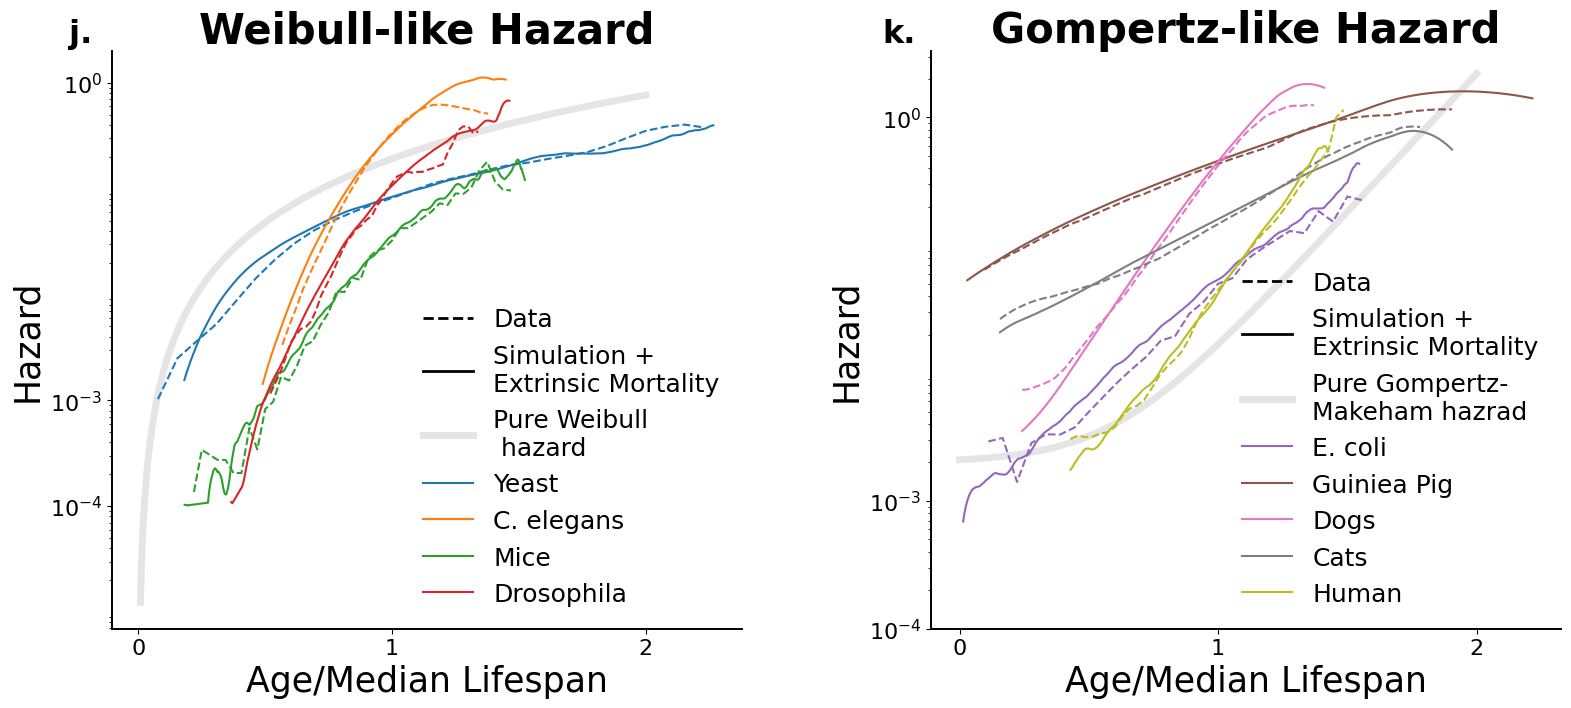

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(17*1.1, 7.5))
# Add horizontal padding between the plots
fig.subplots_adjust(wspace=0.3)
colormap  = plt.get_cmap('tab10')

labels = {'ecoli':'E. coli',
          'yeast': 'Yeast',
           'celegans': 'C. elegans',
             'drosophila_441': 'Drosophila',
               'mice_F': 'Mice',
                 'Labradors_vetCompass': 'Dogs',
                  'cats_vp_M': 'Cats',
                   'Denmark_M_1900_hetro': 'Human',
                   'Guiniea_pig_VC': 'Guiniea Pig'
                   }

ref_t = np.linspace(0,2,1000)
CI = False
trim_by_n = 10

ref_props ={'color':'black','lw':5,'ls':'-','alpha':0.1}
weibull = utils.weibull_hazard(ref_t,shape=3,scale=2.5)
gompertz = utils.gompertz_makeham_hazard(ref_t,intercept=1e-4,slope=5,makeham=2e-3)
ax[0].plot(ref_t[weibull>1e-5],weibull[weibull>1e-5],label='Pure Weibull\n hazard',**ref_props)
ax[1].plot(ref_t,gompertz,label='Pure Gompertz-\nMakeham hazrad', **ref_props)

i=0
for key in ['yeast','celegans','mice_F', 'drosophila_441']:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    
    color = colormap(i)
    lighter_color = lighten_color(color, amount=0.5)
    ds.plotScaledHazard(ax=ax[0], label='', linestyle='--',CI=CI,clean_at=1e-4, trim_by_n=trim_by_n, color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledHazard(ax=ax[0],scale=scale, label=labels[key],CI=CI,clean_at=1e-4, trim_by_n=trim_by_n, color=colormap(i))
    i+=1

for key in ['ecoli', 'Guiniea_pig_VC', 'Labradors_vetCompass','cats_vp_M', 'Denmark_M_1900_hetro']:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    
    color = colormap(i)
    lighter_color = lighten_color(color, amount=0.5)
    ds.plotScaledHazard(ax=ax[1], label='', linestyle='--',CI=CI,clean_at=1e-4,time_range=time_range, trim_by_n=trim_by_n, color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledHazard(ax=ax[1],scale=scale, label=labels[key],CI=CI,clean_at=1e-4,time_range=time_range, trim_by_n=trim_by_n, color=colormap(i))
    i+=1

legend_font = {'size':'18'}
axis_font = {'size':'25'}
ticks_font = {'size':'16'}
title_font = {'size':'30','weight':'bold'}

# Put legend on bottom right of the right plot. 
handles1, labels1 = ax[1].get_legend_handles_labels()
handles_legend1 = []
handles_legend1.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles_legend1.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExtrinsic Mortality'))
handles_legend1 += handles1
ax[1].legend(handles=handles_legend1, loc='lower right', frameon=False, prop=legend_font)

handles0, labels0 = ax[0].get_legend_handles_labels()
handles_legend0 = []
handles_legend0.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles_legend0.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExtrinsic Mortality'))
handles_legend0 += handles0
ax[0].legend(handles=handles_legend0, loc='lower right', frameon=False, prop=legend_font)

# have just three ticks on each axis, add axis labels
for a in ax:
    a.set_xticks([0,1,2])
    a.set_xticklabels([0,1,2], **ticks_font)
    a.set_yticks([1e-4,1e-3,1])
    a.set_yticklabels(['$10^{{-4}}$', '$10^{{-3}}$', '$10^{{0}}$'], **ticks_font)
    a.set_xlabel('Age/Median Lifespan', **axis_font)
    a.set_ylabel('Hazard', **axis_font)

# make axis lines thicker
alw = 1.4
for axis_name in ['top','bottom','left','right']:
    ax[0].spines[axis_name].set_linewidth(alw)
    ax[1].spines[axis_name].set_linewidth(alw)

# Annotate panels as i, j
ax[0].text(-0.05, 1.03, f'j.', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=23, weight='bold')
ax[1].text(-0.05, 1.03, f'k.', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=23, weight='bold')

ax[0].set_title('Weibull-like Hazard', **title_font)
ax[1].set_title('Gompertz-like Hazard', **title_font)

# #add super title
# fig.suptitle('Model fits a wide range of survival data', fontsize=28,weight='bold')

# save figure 
if save_fig:
    plt.savefig(f'plots/hazard_model_fits_different_organisms_for_paper.pdf', format='pdf', dpi=1200)


yeast
celegans
drosophila_441
mice_F
ecoli
Guiniea_pig_VC
Labradors_vetCompass
cats_vp_M
Denmark_M_1900_hetro


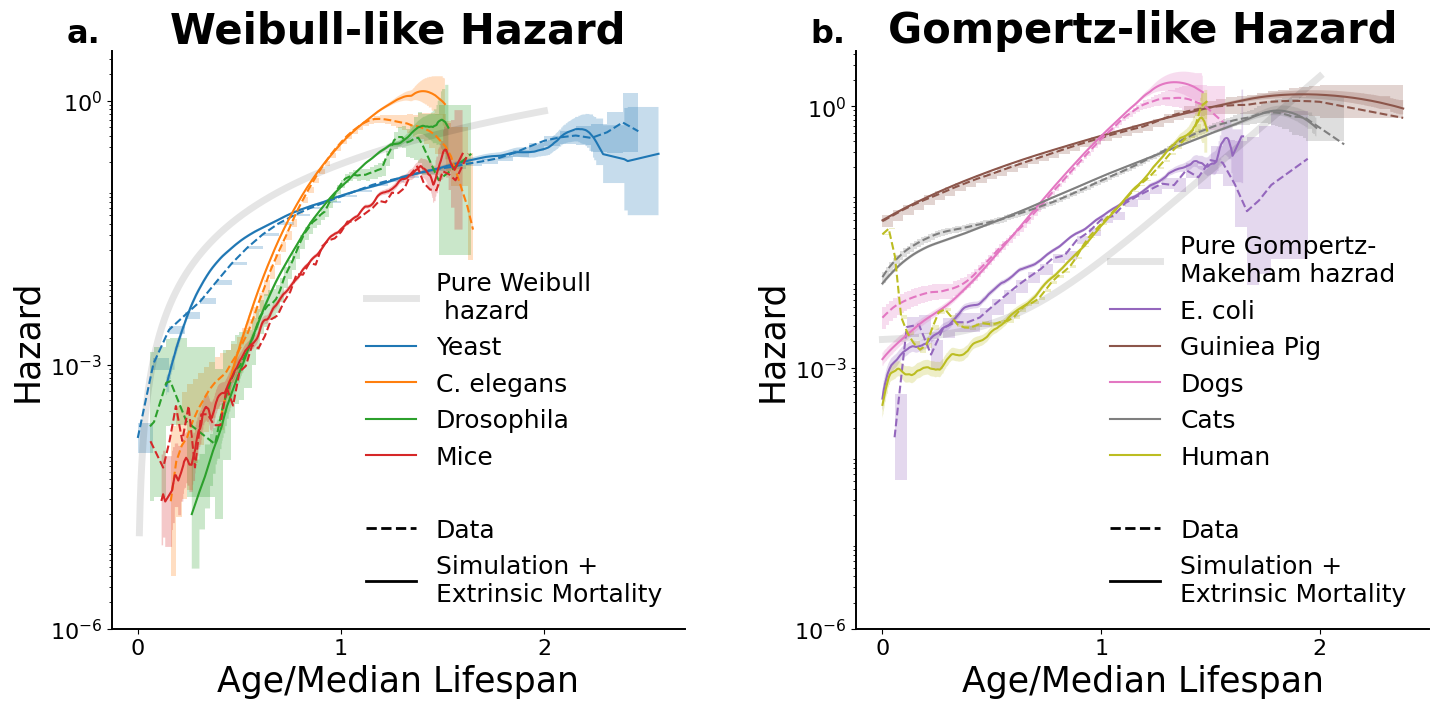

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17*1.0, 7.5))
# Add horizontal padding between the plots
fig.subplots_adjust(wspace=0.3)
colormap  = plt.get_cmap('tab10')

labels = {'ecoli':'E. coli',
          'yeast': 'Yeast',
           'celegans': 'C. elegans',
             'drosophila_441': 'Drosophila',
               'mice_F': 'Mice',
                 'Labradors_vetCompass': 'Dogs',
                  'cats_vp_M': 'Cats',
                   'Denmark_M_1900_hetro': 'Human',
                   'Guiniea_pig_VC': 'Guiniea Pig'
                   }

ref_t = np.linspace(0,2,1000)
CI = True
trim_by_n = 0

ref_props ={'color':'black','lw':5,'ls':'-','alpha':0.1}
weibull = utils.weibull_hazard(ref_t,shape=3,scale=2.5)
gompertz = utils.gompertz_makeham_hazard(ref_t,intercept=1e-4,slope=5,makeham=2e-3)
ax[0].plot(ref_t[weibull>1e-5],weibull[weibull>1e-5],label='Pure Weibull\n hazard',**ref_props)
ax[1].plot(ref_t,gompertz,label='Pure Gompertz-\nMakeham hazrad', **ref_props)

i=0
for key in ['yeast','celegans', 'drosophila_441', 'mice_F', ]:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]

    ds.plotScaledHazard(ax=ax[0], label='', linestyle='--',CI=CI, trim_by_n=trim_by_n, color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledHazard(ax=ax[0],scale=scale, label=labels[key],CI=CI, trim_by_n=trim_by_n, color=colormap(i))
    i+=1

for key in ['ecoli', 'Guiniea_pig_VC', 'Labradors_vetCompass','cats_vp_M', 'Denmark_M_1900_hetro']:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]

    ds.plotScaledHazard(ax=ax[1], label='', linestyle='--',CI=CI, trim_by_n=trim_by_n, color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledHazard(ax=ax[1],scale=scale, label=labels[key],CI=CI, trim_by_n=trim_by_n, color=colormap(i))
    i+=1

legend_font = {'size':'18'}
axis_font = {'size':'25'}
ticks_font = {'size':'16'}
title_font = {'size':'30','weight':'bold'}

# put legend on bottom right of the right plot. Add to legend showing full line is simulation and dashed line is data
handles, legend_labels = ax[1].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='white', lw=0, label=''))
handles.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExtrinsic Mortality'))
ax[1].legend(handles=handles, loc='lower right', frameon=False, prop=legend_font)

handles, legend_labels = ax[0].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='white', lw=0, label=''))
handles.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExtrinsic Mortality'))
ax[0].legend(handles=handles, loc='lower right', frameon=False, prop=legend_font)

# set just three ticks on each axis, add axis labels
for idx in range(2):
    ax[idx].set_xticks([0,1,2])
    ax[idx].set_xticklabels([0,1,2], **ticks_font)
    ax[idx].set_yticks([1e-6,1e-3,1])
    ax[idx].set_yticklabels(['$10^{{-6}}$', '$10^{{-3}}$', '$10^{{0}}$'], **ticks_font)
    ax[idx].set_xlabel('Age/Median Lifespan', **axis_font)
    ax[idx].set_ylabel('Hazard', **axis_font)

# make axis lines thicker
alw = 1.4
for axis_name in ['top','bottom','left','right']:
    ax[0].spines[axis_name].set_linewidth(alw)
    ax[1].spines[axis_name].set_linewidth(alw)

# Label subplots a and b
ax[0].text(-0.05, 1.03, 'a.', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=23, weight='bold')
ax[1].text(-0.05, 1.03, 'b.', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=23, weight='bold')

ax[0].set_title('Weibull-like Hazard', **title_font)
ax[1].set_title('Gompertz-like Hazard', **title_font)

# #add super title
# fig.suptitle('Model fits a wide range of survival data', fontsize=28,weight='bold')

#save figure
if save_fig:
    plt.savefig(f'plots/hazards_model_fits_different_organisms_for_supplement.pdf', format='pdf', dpi=1200)